# Monte carlo option pricing

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import kendalltau
from sklearn.covariance import GraphicalLasso
from tqdm import tqdm
import cvxpy as cp
from matplotlib import pyplot as plt
import datetime

start_date = '2007-01-01'
end_date = '2012-07-09'

data = yf.download(['NVDA', 'SPY'], start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().fillna(0)

[*********************100%%**********************]  2 of 2 completed


In [2]:


lambda_reg = 0.05  # Regularization parameter

def create_difference_operator_matrix(n):
    # The number of rows is n-2 and the number of columns is n
    rows = n - 2
    cols = n
    
    # Initialize the matrix with zeros
    D = np.zeros((rows, cols))
    
    # Fill the diagonals
    for i in range(rows):
        D[i, i] = 1
        D[i, i + 1] = -2
        if i + 2 < cols:
            D[i, i + 2] = 1
    
    return D

n = len(data.fillna(0)['NVDA'])
x = data.fillna(0)['NVDA'].to_numpy()
x = x / np.sqrt(np.sum(x**2))
D = create_difference_operator_matrix(n)


# Define the optimization variable
beta = cp.Variable(n)

# Define the objective function
objective = cp.Minimize(cp.norm2(x - beta)**2 + lambda_reg * cp.norm1(D @ beta))

# Define the problem
problem = cp.Problem(objective)

# Solve the problem
problem.solve()

# Get the solution
beta_hat = beta.value

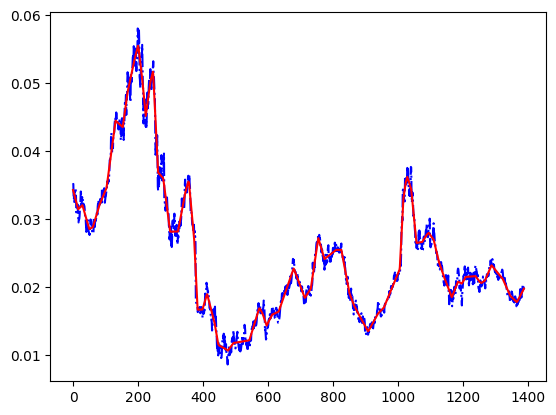

In [3]:


plt.plot(x, '-.b')
plt.plot(beta_hat, '-r')

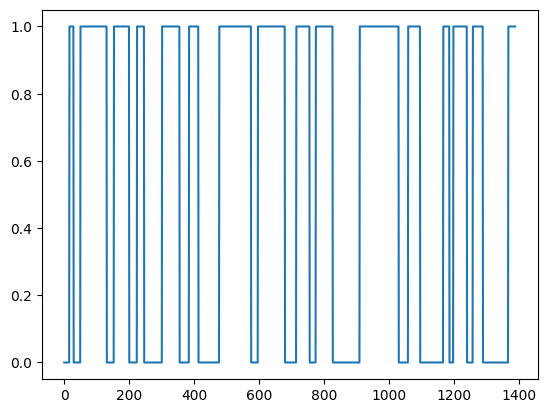

In [4]:
# Calculate the differences between consecutive elements of beta_hat to get the slopes
location = 0
slopes = np.diff(beta_hat[location:])

# Create the state variable: 0 for negative slope, 1 for positive slope
state = (slopes > 0).astype(int)

plt.plot(state)

In [5]:
# We only use the recent
count_0 = np.sum(state == 0)
count_1 = np.sum(state == 1)
count_01 = np.sum(np.diff(state) == 1)
count_10 = np.sum(np.diff(state) == -1)
p_01 = count_01 / count_0
p_10 = count_10 / count_1
p_00 = 1 - p_01
p_11 = 1 - p_10

In [6]:
r = returns.fillna(0)['NVDA'].to_numpy()

r0 = (1 - state) * r[location:-1].T
r1 = state * r[location:-1].T

r0 = r0[r0 != 0]
r1 = r1[r1 != 0]

In [7]:
# naively fitting the data into a t distribution

from scipy import stats

# Fit data to a Student's t-distribution using Maximum Likelihood Estimation (MLE)
params_naive = stats.t.fit(r)

In [8]:
# fitting the state data into two t distribution

params_0 = stats.t.fit(r0)

params_1 = stats.t.fit(r1)

In [9]:
# markov chain based generator

def simulate_markov_chain(size, p00, p01, p10, p11, params_0, params_1):
    # Transition matrix
    transition_matrix = np.array([[p00, p01], [p10, p11]])

    # Initialize state
    states = np.zeros(size, dtype=int)
    
    # Generate state transitions
    for i in range(1, size):
        if states[i-1] == 0:
            states[i] = np.random.choice([0, 1], p=[p00, p01])
        else:
            states[i] = np.random.choice([0, 1], p=[p10, p11])

    # Generate random numbers based on states
    random_numbers = np.zeros(size)
    for i in range(size):
        if states[i] == 0:
            params = params_0
            random_numbers[i] = stats.t.rvs(*params)
        else:
            params = params_1
            random_numbers[i] = stats.t.rvs(*params)
    
    return random_numbers, states

In [10]:
sample_markov, _ = simulate_markov_chain(5000, p_00, p_01, p_10, p_11, params_0, params_1)

In [11]:
params = params_naive
sample_naive = stats.t.rvs(*params, size=5000)

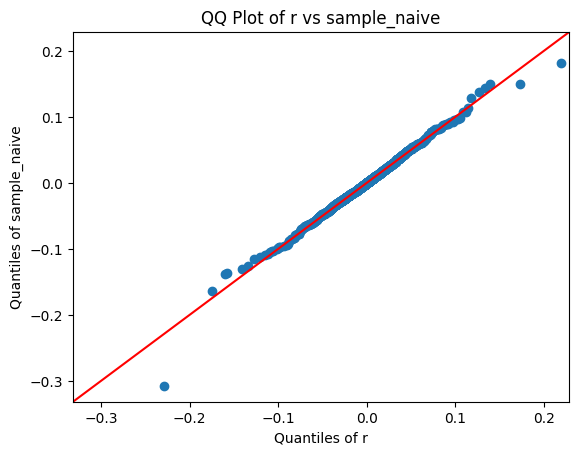

In [12]:
import statsmodels.api as sm
# Generate QQ plot
sm.qqplot_2samples(r, sample_naive, line='45')
plt.xlabel('Quantiles of r')
plt.ylabel('Quantiles of sample_naive')
plt.title('QQ Plot of r vs sample_naive')
plt.show()


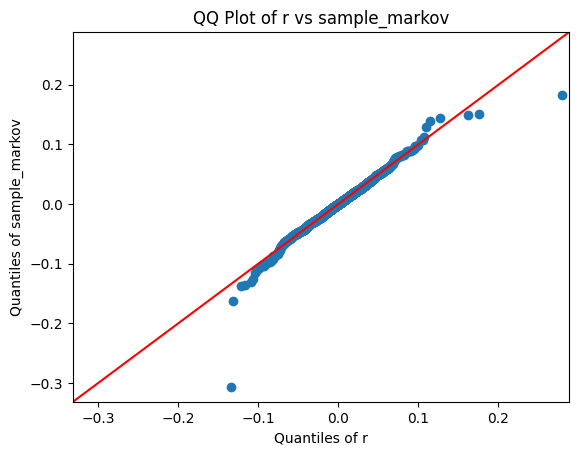

In [13]:
# Generate QQ plot
sm.qqplot_2samples(r, sample_markov, line='45')
plt.xlabel('Quantiles of r')
plt.ylabel('Quantiles of sample_markov')
plt.title('QQ Plot of r vs sample_markov')
plt.show()


In [22]:
def compute_product_markov(p_00, p_01, p_10, p_11, params_0, params_1, T):
    product = np.ones(T+1)
    sample_markov, _ = simulate_markov_chain(T, p_00, p_01, p_10, p_11, params_0, params_1)
    for t in range(1, T + 1):
        product[t] = product[t-1] * (1 + sample_markov[t-1])
    return product

def compute_product_naive(params, T):
    product = np.ones(T+1)
    sample = stats.t.rvs(*params, size=T)
    for t in range(1, T + 1):
        product[t] = product[t-1] * (1 + sample[t-1])
    return product

In [19]:
def option_payoff(option_price, strike_price, asset_value, fees=0, option_type="call"):
    if option_type == "call":
        if asset_value >= strike_price:
            return (asset_value - strike_price - option_price - fees)
        else:
            return (- option_price - fees)
    else:
        if asset_value <= strike_price:
            return (strike_price - asset_value - option_price - fees)
        else:
            return (- option_price - fees)

Payoff expectation: -110.24541994817265


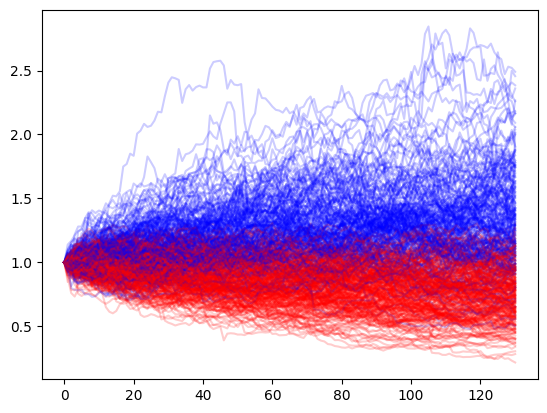

In [23]:
# Call option success rate
T = 130  # Number of business days
initial_asset_price = 130
strike_price = 170
option_price = 120
payoff = 0
number_of_runs = 500
for i in range(number_of_runs):
    products = compute_product_naive(params, T) #compute_product_markov(p_00, p_01, p_10, p_11, params_0, params_1, T)
    asset_value = products[-1]*initial_asset_price
    payoff += option_payoff(option_price, strike_price, asset_value, fees=0)
    if max(products)*initial_asset_price > strike_price:
        plt.plot(products,'b', alpha=0.2)
    else:
        plt.plot(products,'r', alpha=0.2)
exp = payoff/number_of_runs
print(f'Payoff expectation: {exp}')